Experimenting with ways one could do dynamic dithering of the pointings

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import healpy as hp
import surveyStatus as ss
import copy

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
field_data = np.loadtxt('fieldID.dat', delimiter='|', skiprows=1,
                        dtype=zip(['id', 'ra', 'dec'], [int, float, float]))

ra_range = 15.  # Degrees
dec_range = 25.
good = np.where(((field_data['ra'] <= ra_range) | (field_data['ra'] >= 360.-ra_range)) &
                ((field_data['dec'] >= -dec_range) & (field_data['dec'] <= dec_range)))

field_data = field_data[good]
field_data['ra'] = np.radians(field_data['ra'])
field_data['dec'] = np.radians(field_data['dec'])

In [3]:
tracker = ss.countFilterStatus()
hpl = ss.HealpixLookup()

In [4]:
class visit(object):
    def __init__(self):
        self.filter = 'r'

In [5]:
vis = visit()
for obs in field_data:
    pix = hpl.lookup(obs['ra'], obs['dec'])
    tracker.add_visit(vis, pix)

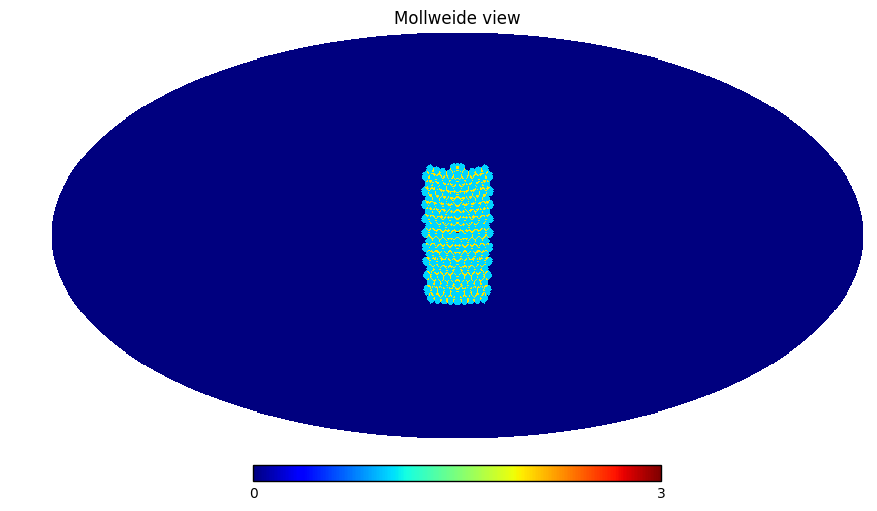

In [6]:
hp.mollview(tracker.survey_map)

In [25]:
def plot_ps(inmap, remove_dipole=True, label=None):
    cl = hp.anafast(hp.remove_dipole(inmap))
    ell = np.arange(np.size(cl))
    if remove_dipole:
        condition = (ell > 1)
    else:
        condition = (ell > 0)
    ell = ell[condition]
    cl = cl[condition]
    plt.plot(ell, (cl * ell * (ell + 1)) / 2.0 / np.pi, label=label)
    plt.xlabel(r'$l$')
    plt.ylabel(r'$l(l+1)C_l/(2\pi)$')
    return cl, ell

monopole: 0.0424805  dipole: lon: -1.69259e-14, lat: 0.558218, amp: 0.122262


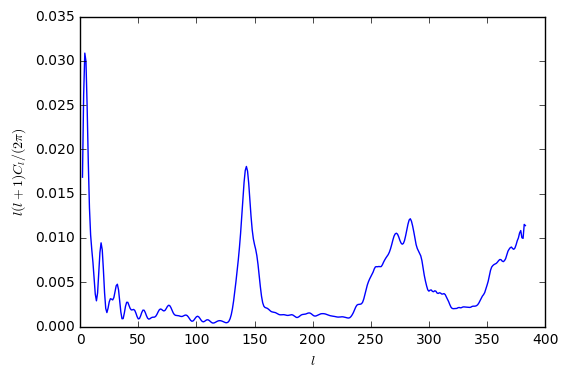

In [8]:
cl, ell = plot_ps(tracker.survey_map.astype(float))

In [9]:
ra_shifts = np.radians(np.linspace(-3., 3., 40.))
dec_shifts = np.radians(np.linspace(-3., 3., 40.))

In [10]:
dithered_maps = []
x = []
y= []
for ra_shift in ra_shifts:
    for dec_shift in dec_shifts:
        x.append(ra_shift)
        y.append(dec_shift)
        new_map = ss.countFilterStatus()
        for obs in field_data:
            pix = hpl.lookup(obs['ra'], obs['dec'])
            new_map.add_visit(vis, pix)
            pix = hpl.lookup(obs['ra']+ra_shift, obs['dec']+dec_shift)
            new_map.add_visit(vis, pix)
        new_map.survey_map[np.where(new_map.survey_map == 0)] = hp.UNSEEN
        dithered_maps.append(new_map)

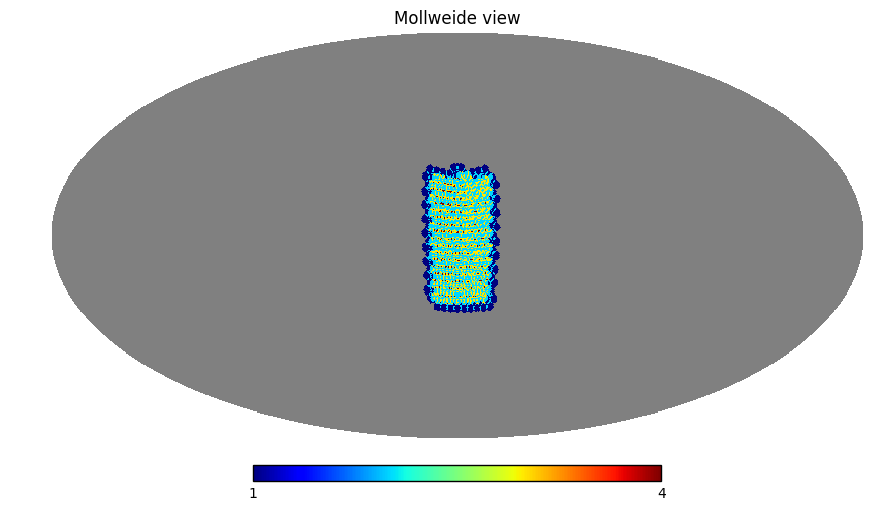

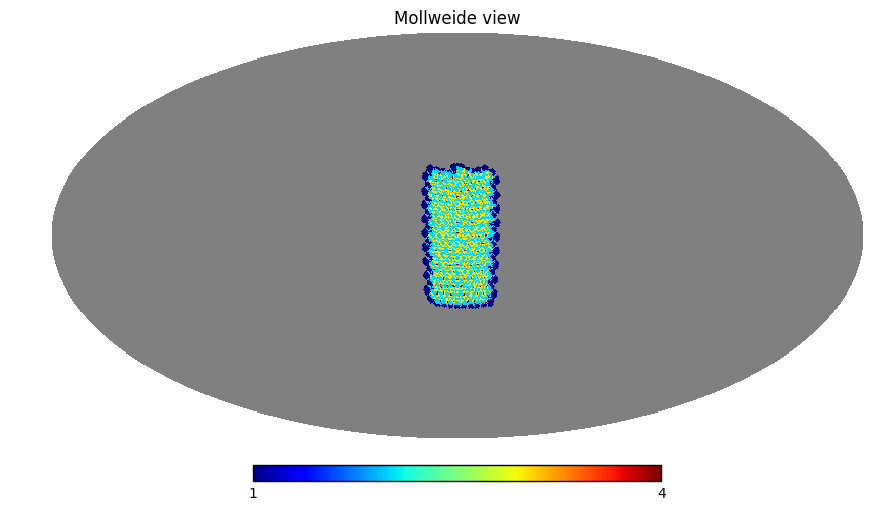

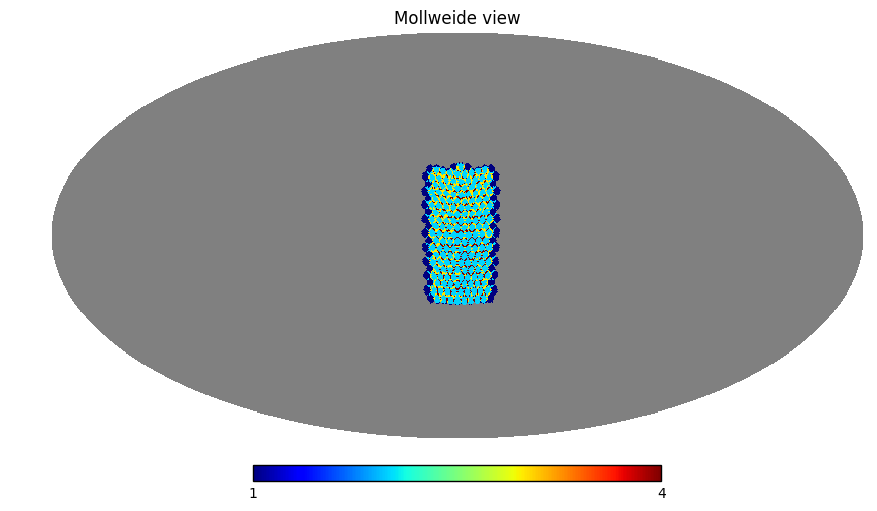

In [11]:
hp.mollview(dithered_maps[0].survey_map)
hp.mollview(dithered_maps[10].survey_map)
hp.mollview(dithered_maps[20].survey_map)


monopole: -7.97436  dipole: lon: -1.18293, lat: -1.16376, amp: 10.5662
monopole: -7.97436  dipole: lon: -1.18293, lat: -1.16376, amp: 10.5662


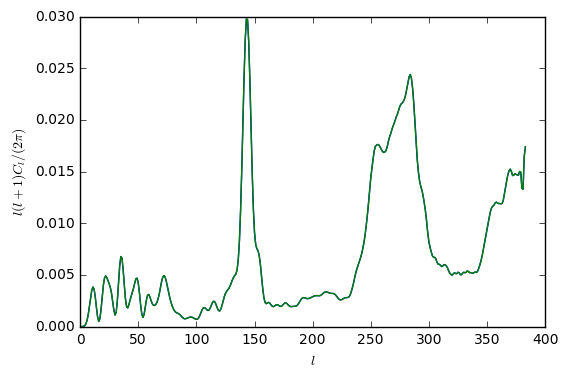

In [12]:
cl, ell = plot_ps(dithered_maps[0].survey_map)
cl, ell = plot_ps(dithered_maps[0].survey_map, remove_dipole=False)

monopole: -7.97436  dipole: lon: -1.18293, lat: -1.16376, amp: 10.5662
monopole: -7.24796  dipole: lon: -1.31952, lat: -0.712667, amp: 9.82245
monopole: -6.46824  dipole: lon: -1.40493, lat: -0.382534, amp: 9.02076
monopole: -5.89143  dipole: lon: -1.78805, lat: 1.01959, amp: 8.4282


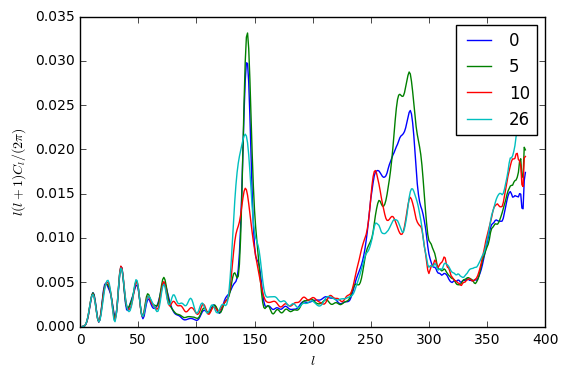

In [26]:
for i in [0,5,10, 26]:
    cl, ell = plot_ps(dithered_maps[i].survey_map, label=str(i))
plt.legend()

In [14]:
ps_s = [np.max(hp.anafast(inmap.survey_map.astype(float))[50:]) for inmap in dithered_maps]
ps_s = np.array(ps_s)

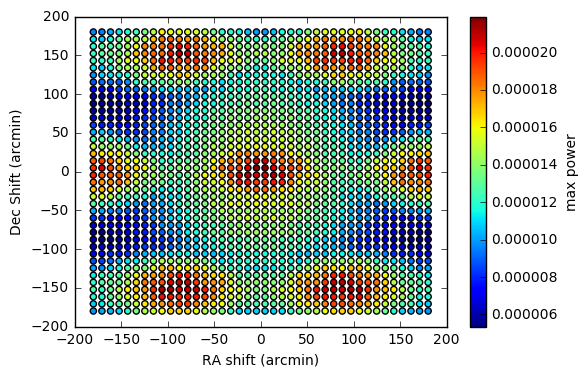

In [15]:
plt.scatter(np.degrees(x)*60., np.degrees(y)*60., c=np.array(ps_s))
cb = plt.colorbar()
plt.xlabel('RA shift (arcmin)')
plt.ylabel('Dec Shift (arcmin)')
cb.set_label('max power')

OK, this makes it look like there's a nice well-defined minimum.  I suppose I could just feed this into a minimization routine--write a function that takes the target pixels, the coadded depth tracker, and so forth. Then find the ra-rotation, dec-rotation, etc, that minimizes the power spectrum.

In [20]:
ps_s = np.array(ps_s)
min_power = np.where(ps_s == ps_s.min())
max_power = np.where(ps_s == ps_s.max())

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app


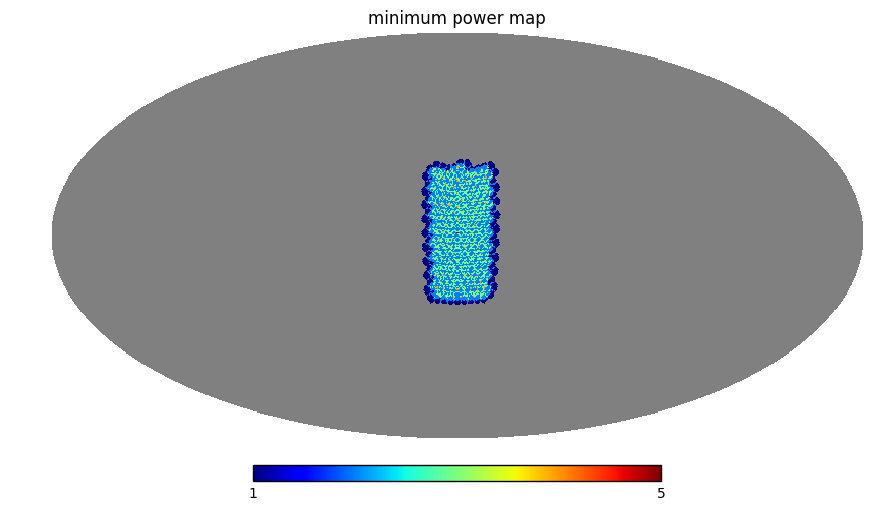

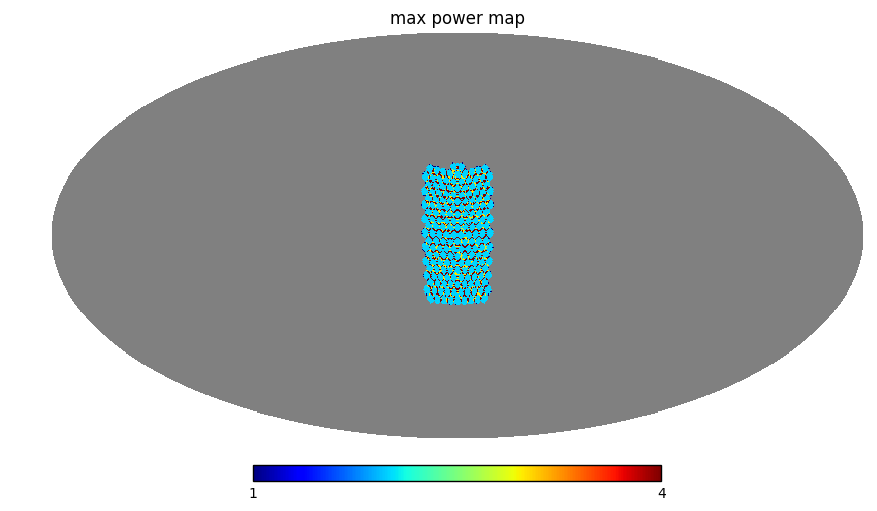

In [21]:
hp.mollview(dithered_maps[min_power[0]].survey_map, title='minimum power map')
hp.mollview(dithered_maps[max_power[0]].survey_map, title='max power map')
